In [ ]:
from ecell4 import *
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct,L,conc,shift,Da,Db,save):
        import numpy as np
        from math import sqrt
        rm = 0.005
        run+=shift
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        D = 1
        kd= 4.0*math.pi*D
        ka = kaf*kd
        f=1.0208582         
        if correct=='new':
            gamma=0.577216
            factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
            PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor            
        voxelr=rm*f
        tm =(2*voxelr)**2/(4*D)        
        duration=0.2#tm*5e4#tm*5e3
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
        Nmv=size[1]*size[2]
        lx,ly,lz=w.actual_lengths()
        N=int(conc*ly*lz)
        Na=N
        Nb=int(5*Na)
        #N=100
        #print(lx,ly,lz)
        #print(size[0],size[1],size[2])
        #print(Nmv*(voxelr*2)**2)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        with species_attributes():
            A |  {'D': str(Da), 'radius':str(voxelr),'location':'M'}
            B |  {'D': str(Db), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():
            A + B > B | ka

        m2 = get_model()
        #print('ka',ka,'Rv',voxelr*2)
        w.bind_to(m2)
        w.add_molecules(Species('A'), Na)
        w.add_molecules(Species('B'), Nb)
        #pid,p=w.get_particle(Species('A'))
        #w.list_structure_particles()
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        #print(sim.dt(),tm)
        tfactor=50
        #obs=NumberObserver(['A'])
        obs = FixedIntervalNumberObserver(tm*tfactor,['A'])
        sim.run(duration,obs)       
        data=obs.data()
        if save==True:
            folder='/home/chew/outputdata/keff/2D/{}kfac{}_Na{}Nb{}_L{}_{}tm_{}rm_Da{}Db{}/'.format(correct,kaf,Na,Nb,L,tfactor,f,Da,Db)
            name = folder+'run'+str(run)
            if not os.path.exists(folder):
                os.makedirs(folder)            
            filename=open(name,'w')
            np.savetxt(name,data,delimiter=',',fmt='%s')
            filename.close()       
        if run==1:
            print('total voxel',Nmv)
            print('Na {},Nb{}, rv{}, Area {}, actual Area {:.4f}'.format(Na,Nb,voxelr,L*L,ly*lz))
            print('100tm',tm*100)
            print('sim.dt(),tm',sim.dt(),tm,tm/sim.dt())
        return 
    job.update({'run':task_id})
    out=singlerun(**job)
    return       

simrun=20000
kaf=100
nproc=500#250#
L=6.5
shift=0
Da=1
Db=0
save=True
# works in low conc, deviate when conc is high
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift,'Da':Da,'Db':Db,'save':save}]    
        ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
        #ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:sge:Submitted batch job 2865798
DEBUG:sge:             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
DEBUG:sge:2865798_[1-20000%5     debug sge-ahu7     chew PD       0:00      1 (None)
DEBUG:sge:           2754893     debug job_01.s    niina  R 5-06:47:58      1 ibc01
DEBUG:sge:           2754894     debug job_08.s    niina  R 5-06:47:58      1 ibc01
DEBUG:sge:           2754895     debug job_09.s    niina  R 5-06:47:58      1 ibc01
DEBUG:sge:           2754896     debug job_14.s    niina  R 5-06:47:58      1 ibc01
DEBUG:sge:           2754897     debug job_16.s    niina  R 5-06:47:58      1 ibc01
DEBUG:sge:           2762398     debug plane_01    niina  R 5-04:48:31      1 ibc04
DEBUG:sge:           2762399     debug plane_02    niina  R 5-04:48:31      1 ibc04
DEBUG:sge:           2762400     debug plane_03    niina  R 5-04:48:31      1 ibc06
DEBUG:sge:          

DEBUG:sge:        2865798_10     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_11     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_12     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_13     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_14     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_15     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_16     debug sge-ahu7     chew  R       0:10      1 ibc28
DEBUG:sge:        2865798_17     debug sge-ahu7     chew  R       0:10      1 ibc06
DEBUG:sge:        2865798_18     debug sge-ahu7     chew  R       0:10      1 ibc06
DEBUG:sge:        2865798_19     debug sge-ahu7     chew  R       0:10      1 ibc06
DEBUG:sge:        2865798_20     debug sge-ahu7     chew  R       0:10      1 ibc06
DEBUG:sge:        2865798_21     debug sge-ahu7     chew  R       0:10      

DEBUG:sge:       2865798_108     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_109     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_110     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_111     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_112     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_113     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_114     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_115     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_116     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_117     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_118     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_119     debug sge-ahu7     chew  R       0:10      

DEBUG:sge:       2865798_206     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_207     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_208     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_209     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_210     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_211     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_212     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_213     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_214     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_215     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_216     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_217     debug sge-ahu7     chew  R       0:10      

DEBUG:sge:       2865798_304     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_305     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_306     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_307     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_308     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_309     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_310     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_311     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_312     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_313     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_314     debug sge-ahu7     chew  R       0:10      1 ibc25
DEBUG:sge:       2865798_315     debug sge-ahu7     chew  R       0:10      

DEBUG:sge:       2865798_393     debug sge-ahu7     chew  R       0:01      1 ibc15
DEBUG:sge:       2865798_394     debug sge-ahu7     chew  R       0:01      1 ibc15
DEBUG:sge:       2865798_367     debug sge-ahu7     chew  R       0:02      1 ibc28
DEBUG:sge:       2865798_368     debug sge-ahu7     chew  R       0:02      1 ibc28
DEBUG:sge:       2865798_366     debug sge-ahu7     chew  R       0:03      1 ibc18
DEBUG:sge:       2865798_359     debug sge-ahu7     chew  R       0:04      1 ibc19
DEBUG:sge:       2865798_360     debug sge-ahu7     chew  R       0:04      1 ibc28
DEBUG:sge:       2865798_361     debug sge-ahu7     chew  R       0:04      1 ibc28
DEBUG:sge:       2865798_362     debug sge-ahu7     chew  R       0:04      1 ibc28
DEBUG:sge:       2865798_363     debug sge-ahu7     chew  R       0:04      1 ibc28
DEBUG:sge:       2865798_364     debug sge-ahu7     chew  R       0:04      1 ibc28
DEBUG:sge:       2865798_365     debug sge-ahu7     chew  R       0:04      

DEBUG:sge:        2865798_84     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_85     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_86     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_87     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_88     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_89     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_90     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:        2865798_91     debug sge-ahu7     chew  R       0:20      1 ibc07
DEBUG:sge:       2865798_108     debug sge-ahu7     chew  R       0:20      1 ibc10
DEBUG:sge:       2865798_109     debug sge-ahu7     chew  R       0:20      1 ibc10
DEBUG:sge:       2865798_110     debug sge-ahu7     chew  R       0:20      1 ibc10
DEBUG:sge:       2865798_111     debug sge-ahu7     chew  R       0:20      

DEBUG:sge:       2865798_213     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_214     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_215     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_216     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_217     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_218     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_219     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_221     debug sge-ahu7     chew  R       0:20      1 ibc20
DEBUG:sge:       2865798_222     debug sge-ahu7     chew  R       0:20      1 ibc20
DEBUG:sge:       2865798_223     debug sge-ahu7     chew  R       0:20      1 ibc20
DEBUG:sge:       2865798_224     debug sge-ahu7     chew  R       0:20      1 ibc20
DEBUG:sge:       2865798_225     debug sge-ahu7     chew  R       0:20      

DEBUG:sge:       2865798_319     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_320     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_321     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_322     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_323     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_324     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_325     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_326     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_327     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_328     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_329     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_330     debug sge-ahu7     chew  R       0:20      

DEBUG:sge:       2865798_423     debug sge-ahu7     chew  R       0:06      1 ibc20
DEBUG:sge:       2865798_424     debug sge-ahu7     chew  R       0:06      1 ibc20
DEBUG:sge:       2865798_395     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_396     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_397     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_398     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_399     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_400     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_401     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_402     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_403     debug sge-ahu7     chew  R       0:10      1 ibc20
DEBUG:sge:       2865798_369     debug sge-ahu7     chew  R       0:11      

DEBUG:sge:        2865798_45     debug sge-ahu7     chew  R       0:30      1 ibc03
DEBUG:sge:        2865798_60     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_62     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_63     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_66     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_67     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_68     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_69     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_70     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_72     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_73     debug sge-ahu7     chew  R       0:30      1 ibc05
DEBUG:sge:        2865798_74     debug sge-ahu7     chew  R       0:30      

DEBUG:sge:       2865798_213     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_214     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_215     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_216     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_217     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_218     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_219     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_237     debug sge-ahu7     chew  R       0:30      1 ibc21
DEBUG:sge:       2865798_238     debug sge-ahu7     chew  R       0:30      1 ibc21
DEBUG:sge:       2865798_240     debug sge-ahu7     chew  R       0:30      1 ibc21
DEBUG:sge:       2865798_241     debug sge-ahu7     chew  R       0:30      1 ibc21
DEBUG:sge:       2865798_242     debug sge-ahu7     chew  R       0:30      

INFO:sge:Waiting for jobids [2865798] to finish
DEBUG:sge:             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
DEBUG:sge:2865798_[502-20000     debug sge-ahu7     chew PD       0:00      1 (Resources)
DEBUG:sge:           2754893     debug job_01.s    niina  R 5-06:48:39      1 ibc01
DEBUG:sge:           2754894     debug job_08.s    niina  R 5-06:48:39      1 ibc01
DEBUG:sge:           2754895     debug job_09.s    niina  R 5-06:48:39      1 ibc01
DEBUG:sge:           2754896     debug job_14.s    niina  R 5-06:48:39      1 ibc01
DEBUG:sge:           2754897     debug job_16.s    niina  R 5-06:48:39      1 ibc01
DEBUG:sge:           2762398     debug plane_01    niina  R 5-04:49:12      1 ibc04
DEBUG:sge:           2762399     debug plane_02    niina  R 5-04:49:12      1 ibc04
DEBUG:sge:           2762400     debug plane_03    niina  R 5-04:49:12      1 ibc06
DEBUG:sge:           2762401     debug plane_04    niina  R 5-04:49:12      1 ibc06
DEBUG:sge: 

DEBUG:sge:       2865798_465     debug sge-ahu7     chew  R       0:10      1 ibc24
DEBUG:sge:       2865798_466     debug sge-ahu7     chew  R       0:10      1 ibc24
DEBUG:sge:       2865798_439     debug sge-ahu7     chew  R       0:11      1 ibc05
DEBUG:sge:       2865798_440     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_441     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_442     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_443     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_444     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_445     debug sge-ahu7     chew  R       0:11      1 ibc03
DEBUG:sge:       2865798_432     debug sge-ahu7     chew  R       0:13      1 ibc03
DEBUG:sge:       2865798_433     debug sge-ahu7     chew  R       0:13      1 ibc03
DEBUG:sge:       2865798_434     debug sge-ahu7     chew  R       0:13      

DEBUG:sge:       2865798_348     debug sge-ahu7     chew  R       0:28      1 ibc03
DEBUG:sge:       2865798_349     debug sge-ahu7     chew  R       0:28      1 ibc03
DEBUG:sge:       2865798_333     debug sge-ahu7     chew  R       0:29      1 ibc13
DEBUG:sge:        2865798_17     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_18     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_19     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_20     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_21     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_22     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_23     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_24     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:        2865798_26     debug sge-ahu7     chew  R       0:41      

DEBUG:sge:       2865798_216     debug sge-ahu7     chew  R       0:41      1 ibc16
DEBUG:sge:       2865798_217     debug sge-ahu7     chew  R       0:41      1 ibc16
DEBUG:sge:       2865798_218     debug sge-ahu7     chew  R       0:41      1 ibc16
DEBUG:sge:       2865798_219     debug sge-ahu7     chew  R       0:41      1 ibc16
DEBUG:sge:       2865798_237     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_238     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_240     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_241     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_242     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_243     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_244     debug sge-ahu7     chew  R       0:41      1 ibc21
DEBUG:sge:       2865798_245     debug sge-ahu7     chew  R       0:41      

DEBUG:sge:           2762405     debug plane_08    niina  R 5-04:49:22      1 ibc19
DEBUG:sge:           2762406     debug plane_09    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762407     debug plane_10    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762408     debug plane_11    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762409     debug plane_12    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762411     debug plane_14    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762412     debug plane_15    niina  R 5-04:49:22      1 ibc18
DEBUG:sge:           2762413     debug plane_16    niina  R 5-04:49:22      1 ibc17
DEBUG:sge:           2765414     debug plane_17    niina  R 5-04:18:49      1 ibc18
DEBUG:sge:           2765415     debug plane_18    niina  R 5-04:18:49      1 ibc18
DEBUG:sge:           2765416     debug plane_19    niina  R 5-04:18:49      1 ibc18
DEBUG:sge:           2765417     debug plane_20    niina  R 5-04:18:49      

DEBUG:sge:       2865798_491     debug sge-ahu7     chew  R       0:14      1 ibc20
DEBUG:sge:       2865798_492     debug sge-ahu7     chew  R       0:14      1 ibc20
DEBUG:sge:       2865798_493     debug sge-ahu7     chew  R       0:14      1 ibc20
DEBUG:sge:       2865798_494     debug sge-ahu7     chew  R       0:14      1 ibc20
DEBUG:sge:       2865798_495     debug sge-ahu7     chew  R       0:14      1 ibc20
DEBUG:sge:       2865798_469     debug sge-ahu7     chew  R       0:16      1 ibc05
DEBUG:sge:       2865798_470     debug sge-ahu7     chew  R       0:16      1 ibc14
DEBUG:sge:       2865798_471     debug sge-ahu7     chew  R       0:16      1 ibc14
DEBUG:sge:       2865798_472     debug sge-ahu7     chew  R       0:16      1 ibc14
DEBUG:sge:       2865798_473     debug sge-ahu7     chew  R       0:16      1 ibc14
DEBUG:sge:       2865798_474     debug sge-ahu7     chew  R       0:16      1 ibc14
DEBUG:sge:       2865798_468     debug sge-ahu7     chew  R       0:17      

DEBUG:sge:       2865798_367     debug sge-ahu7     chew  R       0:33      1 ibc28
DEBUG:sge:       2865798_368     debug sge-ahu7     chew  R       0:33      1 ibc28
DEBUG:sge:       2865798_366     debug sge-ahu7     chew  R       0:34      1 ibc18
DEBUG:sge:       2865798_359     debug sge-ahu7     chew  R       0:35      1 ibc19
DEBUG:sge:       2865798_360     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_361     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_362     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_363     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_364     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_365     debug sge-ahu7     chew  R       0:35      1 ibc28
DEBUG:sge:       2865798_351     debug sge-ahu7     chew  R       0:37      1 ibc06
DEBUG:sge:       2865798_352     debug sge-ahu7     chew  R       0:37      

DEBUG:sge:       2865798_204     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_206     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_207     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_208     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_209     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_210     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_212     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_213     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_214     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_215     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_216     debug sge-ahu7     chew  R       0:51      1 ibc16
DEBUG:sge:       2865798_217     debug sge-ahu7     chew  R       0:51      

DEBUG:sge:           2765421     debug plane_24    niina  R 5-04:18:58      1 ibc18
DEBUG:sge:           2765422     debug plane_25    niina  R 5-04:18:58      1 ibc18
DEBUG:sge:           2765423     debug plane_26    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765424     debug plane_27    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765425     debug plane_28    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765426     debug plane_29    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765427     debug plane_30    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765428     debug plane_31    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765429     debug plane_32    niina  R 5-04:18:58      1 ibc19
DEBUG:sge:           2765430     debug  re01.sh    niina  R 5-03:45:15      1 ibc19
DEBUG:sge:           2765431     debug  re08.sh    niina  R 5-03:45:09      1 ibc19
DEBUG:sge:           2765432     debug  re09.sh    niina  R 5-03:45:06      

DEBUG:sge:       2865798_507     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_508     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_509     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_510     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_511     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_512     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_513     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_514     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_515     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_516     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_517     debug sge-ahu7     chew  R       0:20      1 ibc26
DEBUG:sge:       2865798_518     debug sge-ahu7     chew  R       0:20      

DEBUG:sge:       2865798_410     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_411     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_412     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_413     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_415     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_416     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_417     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_418     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_419     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_421     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_422     debug sge-ahu7     chew  R       0:37      1 ibc13
DEBUG:sge:       2865798_399     debug sge-ahu7     chew  R       0:41      

DEBUG:sge:       2865798_152     debug sge-ahu7     chew  R       1:01      1 ibc17
DEBUG:sge:       2865798_153     debug sge-ahu7     chew  R       1:01      1 ibc17
DEBUG:sge:       2865798_154     debug sge-ahu7     chew  R       1:01      1 ibc17
DEBUG:sge:       2865798_155     debug sge-ahu7     chew  R       1:01      1 ibc17
DEBUG:sge:       2865798_181     debug sge-ahu7     chew  R       1:01      1 ibc14
DEBUG:sge:       2865798_188     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_191     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_197     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_198     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_199     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_200     debug sge-ahu7     chew  R       1:01      1 ibc15
DEBUG:sge:       2865798_202     debug sge-ahu7     chew  R       1:01      

DEBUG:sge:       2865798_645     debug sge-ahu7     chew  R       0:01      1 ibc05
DEBUG:sge:       2865798_646     debug sge-ahu7     chew  R       0:01      1 ibc05
DEBUG:sge:       2865798_647     debug sge-ahu7     chew  R       0:01      1 ibc07
DEBUG:sge:       2865798_637     debug sge-ahu7     chew  R       0:02      1 ibc23
DEBUG:sge:       2865798_638     debug sge-ahu7     chew  R       0:02      1 ibc25
DEBUG:sge:       2865798_639     debug sge-ahu7     chew  R       0:02      1 ibc23
DEBUG:sge:       2865798_640     debug sge-ahu7     chew  R       0:02      1 ibc06
DEBUG:sge:       2865798_641     debug sge-ahu7     chew  R       0:02      1 ibc10
DEBUG:sge:       2865798_642     debug sge-ahu7     chew  R       0:02      1 ibc22
DEBUG:sge:       2865798_643     debug sge-ahu7     chew  R       0:02      1 ibc15
DEBUG:sge:       2865798_635     debug sge-ahu7     chew  R       0:03      1 ibc10
DEBUG:sge:       2865798_636     debug sge-ahu7     chew  R       0:03      

DEBUG:sge:       2865798_548     debug sge-ahu7     chew  R       0:21      1 ibc22
DEBUG:sge:       2865798_546     debug sge-ahu7     chew  R       0:22      1 ibc23
DEBUG:sge:       2865798_547     debug sge-ahu7     chew  R       0:22      1 ibc11
DEBUG:sge:       2865798_542     debug sge-ahu7     chew  R       0:23      1 ibc16
DEBUG:sge:       2865798_543     debug sge-ahu7     chew  R       0:23      1 ibc25
DEBUG:sge:       2865798_544     debug sge-ahu7     chew  R       0:23      1 ibc06
DEBUG:sge:       2865798_545     debug sge-ahu7     chew  R       0:23      1 ibc17
DEBUG:sge:       2865798_541     debug sge-ahu7     chew  R       0:24      1 ibc21
DEBUG:sge:       2865798_538     debug sge-ahu7     chew  R       0:25      1 ibc06
DEBUG:sge:       2865798_539     debug sge-ahu7     chew  R       0:25      1 ibc24
DEBUG:sge:       2865798_540     debug sge-ahu7     chew  R       0:25      1 ibc22
DEBUG:sge:       2865798_536     debug sge-ahu7     chew  R       0:26      

DEBUG:sge:       2865798_462     debug sge-ahu7     chew  R       0:40      1 ibc24
DEBUG:sge:       2865798_463     debug sge-ahu7     chew  R       0:40      1 ibc24
DEBUG:sge:       2865798_464     debug sge-ahu7     chew  R       0:40      1 ibc24
DEBUG:sge:       2865798_465     debug sge-ahu7     chew  R       0:40      1 ibc24
DEBUG:sge:       2865798_466     debug sge-ahu7     chew  R       0:40      1 ibc24
DEBUG:sge:       2865798_440     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_441     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_442     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_443     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_444     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_445     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_432     debug sge-ahu7     chew  R       0:43      

DEBUG:sge:       2865798_349     debug sge-ahu7     chew  R       0:58      1 ibc03
DEBUG:sge:       2865798_333     debug sge-ahu7     chew  R       0:59      1 ibc13
DEBUG:sge:        2865798_20     debug sge-ahu7     chew  R       1:11      1 ibc06
DEBUG:sge:        2865798_28     debug sge-ahu7     chew  R       1:11      1 ibc06
DEBUG:sge:        2865798_34     debug sge-ahu7     chew  R       1:11      1 ibc04
DEBUG:sge:        2865798_43     debug sge-ahu7     chew  R       1:11      1 ibc04
DEBUG:sge:       2865798_108     debug sge-ahu7     chew  R       1:11      1 ibc10
DEBUG:sge:       2865798_120     debug sge-ahu7     chew  R       1:11      1 ibc10
DEBUG:sge:       2865798_122     debug sge-ahu7     chew  R       1:11      1 ibc10
DEBUG:sge:       2865798_123     debug sge-ahu7     chew  R       1:11      1 ibc10
DEBUG:sge:       2865798_142     debug sge-ahu7     chew  R       1:11      1 ibc17
DEBUG:sge:       2865798_146     debug sge-ahu7     chew  R       1:11      

DEBUG:sge:       2865798_658     debug sge-ahu7     chew  R       0:08      1 ibc04
DEBUG:sge:       2865798_653     debug sge-ahu7     chew  R       0:09      1 ibc10
DEBUG:sge:       2865798_654     debug sge-ahu7     chew  R       0:09      1 ibc28
DEBUG:sge:       2865798_655     debug sge-ahu7     chew  R       0:09      1 ibc07
DEBUG:sge:       2865798_649     debug sge-ahu7     chew  R       0:10      1 ibc10
DEBUG:sge:       2865798_650     debug sge-ahu7     chew  R       0:10      1 ibc03
DEBUG:sge:       2865798_651     debug sge-ahu7     chew  R       0:10      1 ibc06
DEBUG:sge:       2865798_652     debug sge-ahu7     chew  R       0:10      1 ibc16
DEBUG:sge:       2865798_648     debug sge-ahu7     chew  R       0:11      1 ibc17
DEBUG:sge:       2865798_644     debug sge-ahu7     chew  R       0:12      1 ibc05
DEBUG:sge:       2865798_645     debug sge-ahu7     chew  R       0:12      1 ibc05
DEBUG:sge:       2865798_646     debug sge-ahu7     chew  R       0:12      

DEBUG:sge:       2865798_558     debug sge-ahu7     chew  R       0:30      1 ibc10
DEBUG:sge:       2865798_559     debug sge-ahu7     chew  R       0:30      1 ibc10
DEBUG:sge:       2865798_560     debug sge-ahu7     chew  R       0:30      1 ibc21
DEBUG:sge:       2865798_561     debug sge-ahu7     chew  R       0:30      1 ibc17
DEBUG:sge:       2865798_549     debug sge-ahu7     chew  R       0:31      1 ibc14
DEBUG:sge:       2865798_550     debug sge-ahu7     chew  R       0:31      1 ibc10
DEBUG:sge:       2865798_551     debug sge-ahu7     chew  R       0:31      1 ibc04
DEBUG:sge:       2865798_552     debug sge-ahu7     chew  R       0:31      1 ibc04
DEBUG:sge:       2865798_553     debug sge-ahu7     chew  R       0:31      1 ibc04
DEBUG:sge:       2865798_554     debug sge-ahu7     chew  R       0:31      1 ibc04
DEBUG:sge:       2865798_548     debug sge-ahu7     chew  R       0:32      1 ibc22
DEBUG:sge:       2865798_546     debug sge-ahu7     chew  R       0:33      

DEBUG:sge:       2865798_452     debug sge-ahu7     chew  R       0:51      1 ibc07
DEBUG:sge:       2865798_453     debug sge-ahu7     chew  R       0:51      1 ibc07
DEBUG:sge:       2865798_454     debug sge-ahu7     chew  R       0:51      1 ibc07
DEBUG:sge:       2865798_455     debug sge-ahu7     chew  R       0:51      1 ibc07
DEBUG:sge:       2865798_456     debug sge-ahu7     chew  R       0:51      1 ibc07
DEBUG:sge:       2865798_457     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_458     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_459     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_460     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_461     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_462     debug sge-ahu7     chew  R       0:51      1 ibc24
DEBUG:sge:       2865798_463     debug sge-ahu7     chew  R       0:51      

DEBUG:sge:       2865798_342     debug sge-ahu7     chew  R       1:09      1 ibc04
DEBUG:sge:       2865798_343     debug sge-ahu7     chew  R       1:09      1 ibc23
DEBUG:sge:       2865798_344     debug sge-ahu7     chew  R       1:09      1 ibc11
DEBUG:sge:       2865798_345     debug sge-ahu7     chew  R       1:09      1 ibc25
DEBUG:sge:       2865798_346     debug sge-ahu7     chew  R       1:09      1 ibc11
DEBUG:sge:       2865798_347     debug sge-ahu7     chew  R       1:09      1 ibc03
DEBUG:sge:       2865798_349     debug sge-ahu7     chew  R       1:09      1 ibc03
DEBUG:sge:       2865798_333     debug sge-ahu7     chew  R       1:10      1 ibc13
DEBUG:sge:       2865798_108     debug sge-ahu7     chew  R       1:22      1 ibc10
DEBUG:sge:       2865798_142     debug sge-ahu7     chew  R       1:22      1 ibc17
DEBUG:sge:       2865798_152     debug sge-ahu7     chew  R       1:22      1 ibc17
DEBUG:sge:       2865798_191     debug sge-ahu7     chew  R       1:22      

DEBUG:sge:       2865798_656     debug sge-ahu7     chew  R       0:18      1 ibc21
DEBUG:sge:       2865798_657     debug sge-ahu7     chew  R       0:18      1 ibc21
DEBUG:sge:       2865798_658     debug sge-ahu7     chew  R       0:18      1 ibc04
DEBUG:sge:       2865798_653     debug sge-ahu7     chew  R       0:19      1 ibc10
DEBUG:sge:       2865798_654     debug sge-ahu7     chew  R       0:19      1 ibc28
DEBUG:sge:       2865798_655     debug sge-ahu7     chew  R       0:19      1 ibc07
DEBUG:sge:       2865798_649     debug sge-ahu7     chew  R       0:20      1 ibc10
DEBUG:sge:       2865798_650     debug sge-ahu7     chew  R       0:20      1 ibc03
DEBUG:sge:       2865798_651     debug sge-ahu7     chew  R       0:20      1 ibc06
DEBUG:sge:       2865798_652     debug sge-ahu7     chew  R       0:20      1 ibc16
DEBUG:sge:       2865798_648     debug sge-ahu7     chew  R       0:21      1 ibc17
DEBUG:sge:       2865798_644     debug sge-ahu7     chew  R       0:22      

DEBUG:sge:       2865798_556     debug sge-ahu7     chew  R       0:40      1 ibc10
DEBUG:sge:       2865798_557     debug sge-ahu7     chew  R       0:40      1 ibc14
DEBUG:sge:       2865798_558     debug sge-ahu7     chew  R       0:40      1 ibc10
DEBUG:sge:       2865798_559     debug sge-ahu7     chew  R       0:40      1 ibc10
DEBUG:sge:       2865798_560     debug sge-ahu7     chew  R       0:40      1 ibc21
DEBUG:sge:       2865798_561     debug sge-ahu7     chew  R       0:40      1 ibc17
DEBUG:sge:       2865798_549     debug sge-ahu7     chew  R       0:41      1 ibc14
DEBUG:sge:       2865798_550     debug sge-ahu7     chew  R       0:41      1 ibc10
DEBUG:sge:       2865798_551     debug sge-ahu7     chew  R       0:41      1 ibc04
DEBUG:sge:       2865798_552     debug sge-ahu7     chew  R       0:41      1 ibc04
DEBUG:sge:       2865798_553     debug sge-ahu7     chew  R       0:41      1 ibc04
DEBUG:sge:       2865798_554     debug sge-ahu7     chew  R       0:41      

DEBUG:sge:       2865798_450     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_451     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_452     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_453     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_454     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_455     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_456     debug sge-ahu7     chew  R       1:01      1 ibc07
DEBUG:sge:       2865798_457     debug sge-ahu7     chew  R       1:01      1 ibc24
DEBUG:sge:       2865798_458     debug sge-ahu7     chew  R       1:01      1 ibc24
DEBUG:sge:       2865798_459     debug sge-ahu7     chew  R       1:01      1 ibc24
DEBUG:sge:       2865798_460     debug sge-ahu7     chew  R       1:01      1 ibc24
DEBUG:sge:       2865798_461     debug sge-ahu7     chew  R       1:01      

DEBUG:sge:       2865798_108     debug sge-ahu7     chew  R       1:32      1 ibc10
DEBUG:sge:       2865798_152     debug sge-ahu7     chew  R       1:32      1 ibc17
DEBUG:sge:       2865798_213     debug sge-ahu7     chew  R       1:32      1 ibc16
DEBUG:sge:       2865798_249     debug sge-ahu7     chew  R       1:32      1 ibc21
DEBUG:sge:       2865798_264     debug sge-ahu7     chew  R       1:32      1 ibc22
DEBUG:sge:       2865798_278     debug sge-ahu7     chew  R       1:32      1 ibc23
DEBUG:sge:       2865798_304     debug sge-ahu7     chew  R       1:32      1 ibc25
DEBUG:sge:
INFO:sge:Job 2865798 must be queued, running or being transferred
INFO:sge:Waiting for jobids [2865798] to finish
DEBUG:sge:             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
DEBUG:sge:2865798_[702-20000     debug sge-ahu7     chew PD       0:00      1 (Resources)
DEBUG:sge:           2754893     debug job_01.s    niina  R 5-06:49:40      1 ibc01
DEBUG:sge:        

DEBUG:sge:       2865798_653     debug sge-ahu7     chew  R       0:29      1 ibc10
DEBUG:sge:       2865798_654     debug sge-ahu7     chew  R       0:29      1 ibc28
DEBUG:sge:       2865798_655     debug sge-ahu7     chew  R       0:29      1 ibc07
DEBUG:sge:       2865798_649     debug sge-ahu7     chew  R       0:30      1 ibc10
DEBUG:sge:       2865798_650     debug sge-ahu7     chew  R       0:30      1 ibc03
DEBUG:sge:       2865798_651     debug sge-ahu7     chew  R       0:30      1 ibc06
DEBUG:sge:       2865798_652     debug sge-ahu7     chew  R       0:30      1 ibc16
DEBUG:sge:       2865798_648     debug sge-ahu7     chew  R       0:31      1 ibc17
DEBUG:sge:       2865798_644     debug sge-ahu7     chew  R       0:32      1 ibc05
DEBUG:sge:       2865798_645     debug sge-ahu7     chew  R       0:32      1 ibc05
DEBUG:sge:       2865798_646     debug sge-ahu7     chew  R       0:32      1 ibc05
DEBUG:sge:       2865798_647     debug sge-ahu7     chew  R       0:32      

DEBUG:sge:       2865798_559     debug sge-ahu7     chew  R       0:50      1 ibc10
DEBUG:sge:       2865798_560     debug sge-ahu7     chew  R       0:50      1 ibc21
DEBUG:sge:       2865798_561     debug sge-ahu7     chew  R       0:50      1 ibc17
DEBUG:sge:       2865798_549     debug sge-ahu7     chew  R       0:51      1 ibc14
DEBUG:sge:       2865798_550     debug sge-ahu7     chew  R       0:51      1 ibc10
DEBUG:sge:       2865798_551     debug sge-ahu7     chew  R       0:51      1 ibc04
DEBUG:sge:       2865798_552     debug sge-ahu7     chew  R       0:51      1 ibc04
DEBUG:sge:       2865798_553     debug sge-ahu7     chew  R       0:51      1 ibc04
DEBUG:sge:       2865798_554     debug sge-ahu7     chew  R       0:51      1 ibc04
DEBUG:sge:       2865798_548     debug sge-ahu7     chew  R       0:52      1 ibc22
DEBUG:sge:       2865798_546     debug sge-ahu7     chew  R       0:53      1 ibc23
DEBUG:sge:       2865798_547     debug sge-ahu7     chew  R       0:53      

DEBUG:sge:       2865798_455     debug sge-ahu7     chew  R       1:11      1 ibc07
DEBUG:sge:       2865798_456     debug sge-ahu7     chew  R       1:11      1 ibc07
DEBUG:sge:       2865798_457     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_458     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_459     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_460     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_461     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_462     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_463     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_464     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_465     debug sge-ahu7     chew  R       1:11      1 ibc24
DEBUG:sge:       2865798_466     debug sge-ahu7     chew  R       1:11      

DEBUG:sge:           2754897     debug job_16.s    niina  R 5-06:49:51      1 ibc01
DEBUG:sge:           2762398     debug plane_01    niina  R 5-04:50:24      1 ibc04
DEBUG:sge:           2762399     debug plane_02    niina  R 5-04:50:24      1 ibc04
DEBUG:sge:           2762400     debug plane_03    niina  R 5-04:50:24      1 ibc06
DEBUG:sge:           2762401     debug plane_04    niina  R 5-04:50:24      1 ibc06
DEBUG:sge:           2762402     debug plane_05    niina  R 5-04:50:24      1 ibc06
DEBUG:sge:           2762403     debug plane_06    niina  R 5-04:50:24      1 ibc19
DEBUG:sge:           2762404     debug plane_07    niina  R 5-04:50:24      1 ibc19
DEBUG:sge:           2762405     debug plane_08    niina  R 5-04:50:24      1 ibc19
DEBUG:sge:           2762406     debug plane_09    niina  R 5-04:50:24      1 ibc18
DEBUG:sge:           2762407     debug plane_10    niina  R 5-04:50:24      1 ibc18
DEBUG:sge:           2762408     debug plane_11    niina  R 5-04:50:24      

DEBUG:sge:       2865798_658     debug sge-ahu7     chew  R       0:39      1 ibc04
DEBUG:sge:       2865798_653     debug sge-ahu7     chew  R       0:40      1 ibc10
DEBUG:sge:       2865798_654     debug sge-ahu7     chew  R       0:40      1 ibc28
DEBUG:sge:       2865798_655     debug sge-ahu7     chew  R       0:40      1 ibc07
DEBUG:sge:       2865798_649     debug sge-ahu7     chew  R       0:41      1 ibc10
DEBUG:sge:       2865798_650     debug sge-ahu7     chew  R       0:41      1 ibc03
DEBUG:sge:       2865798_651     debug sge-ahu7     chew  R       0:41      1 ibc06
DEBUG:sge:       2865798_652     debug sge-ahu7     chew  R       0:41      1 ibc16
DEBUG:sge:       2865798_648     debug sge-ahu7     chew  R       0:42      1 ibc17
DEBUG:sge:       2865798_644     debug sge-ahu7     chew  R       0:43      1 ibc05
DEBUG:sge:       2865798_645     debug sge-ahu7     chew  R       0:43      1 ibc05
DEBUG:sge:       2865798_646     debug sge-ahu7     chew  R       0:43      

DEBUG:sge:       2865798_558     debug sge-ahu7     chew  R       1:01      1 ibc10
DEBUG:sge:       2865798_559     debug sge-ahu7     chew  R       1:01      1 ibc10
DEBUG:sge:       2865798_560     debug sge-ahu7     chew  R       1:01      1 ibc21
DEBUG:sge:       2865798_561     debug sge-ahu7     chew  R       1:01      1 ibc17
DEBUG:sge:       2865798_549     debug sge-ahu7     chew  R       1:02      1 ibc14
DEBUG:sge:       2865798_550     debug sge-ahu7     chew  R       1:02      1 ibc10
DEBUG:sge:       2865798_551     debug sge-ahu7     chew  R       1:02      1 ibc04
DEBUG:sge:       2865798_552     debug sge-ahu7     chew  R       1:02      1 ibc04
DEBUG:sge:       2865798_553     debug sge-ahu7     chew  R       1:02      1 ibc04
DEBUG:sge:       2865798_554     debug sge-ahu7     chew  R       1:02      1 ibc04
DEBUG:sge:       2865798_548     debug sge-ahu7     chew  R       1:03      1 ibc22
DEBUG:sge:       2865798_546     debug sge-ahu7     chew  R       1:04      

DEBUG:sge:       2865798_459     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_460     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_461     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_462     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_463     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_464     debug sge-ahu7     chew  R       1:22      1 ibc24
DEBUG:sge:       2865798_440     debug sge-ahu7     chew  R       1:23      1 ibc03
DEBUG:sge:       2865798_441     debug sge-ahu7     chew  R       1:23      1 ibc03
DEBUG:sge:       2865798_442     debug sge-ahu7     chew  R       1:23      1 ibc03
DEBUG:sge:       2865798_443     debug sge-ahu7     chew  R       1:23      1 ibc03
DEBUG:sge:       2865798_444     debug sge-ahu7     chew  R       1:23      1 ibc03
DEBUG:sge:       2865798_445     debug sge-ahu7     chew  R       1:23      

DEBUG:sge:           2762413     debug plane_16    niina  R 5-04:50:34      1 ibc17
DEBUG:sge:           2765414     debug plane_17    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765415     debug plane_18    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765416     debug plane_19    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765417     debug plane_20    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765418     debug plane_21    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765419     debug plane_22    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765420     debug plane_23    niina  R 5-04:20:01      1 ibc18
DEBUG:sge:           2765421     debug plane_24    niina  R 5-04:20:00      1 ibc18
DEBUG:sge:           2765422     debug plane_25    niina  R 5-04:20:00      1 ibc18
DEBUG:sge:           2765423     debug plane_26    niina  R 5-04:20:00      1 ibc19
DEBUG:sge:           2765424     debug plane_27    niina  R 5-04:20:00      

DEBUG:sge:       2865798_693     debug sge-ahu7     chew  R       0:30      1 ibc22
DEBUG:sge:       2865798_690     debug sge-ahu7     chew  R       0:31      1 ibc17
DEBUG:sge:       2865798_691     debug sge-ahu7     chew  R       0:31      1 ibc23
DEBUG:sge:       2865798_692     debug sge-ahu7     chew  R       0:31      1 ibc21
DEBUG:sge:       2865798_687     debug sge-ahu7     chew  R       0:32      1 ibc20
DEBUG:sge:       2865798_688     debug sge-ahu7     chew  R       0:32      1 ibc16
DEBUG:sge:       2865798_684     debug sge-ahu7     chew  R       0:33      1 ibc21
DEBUG:sge:       2865798_685     debug sge-ahu7     chew  R       0:33      1 ibc22
DEBUG:sge:       2865798_686     debug sge-ahu7     chew  R       0:33      1 ibc22
DEBUG:sge:       2865798_683     debug sge-ahu7     chew  R       0:34      1 ibc15
DEBUG:sge:       2865798_682     debug sge-ahu7     chew  R       0:35      1 ibc17
DEBUG:sge:       2865798_678     debug sge-ahu7     chew  R       0:36      

DEBUG:sge:       2865798_589     debug sge-ahu7     chew  R       1:04      1 ibc04
DEBUG:sge:       2865798_590     debug sge-ahu7     chew  R       1:04      1 ibc06
DEBUG:sge:       2865798_586     debug sge-ahu7     chew  R       1:05      1 ibc25
DEBUG:sge:       2865798_587     debug sge-ahu7     chew  R       1:05      1 ibc25
DEBUG:sge:       2865798_588     debug sge-ahu7     chew  R       1:05      1 ibc25
DEBUG:sge:       2865798_584     debug sge-ahu7     chew  R       1:06      1 ibc23
DEBUG:sge:       2865798_585     debug sge-ahu7     chew  R       1:06      1 ibc04
DEBUG:sge:       2865798_578     debug sge-ahu7     chew  R       1:07      1 ibc22
DEBUG:sge:       2865798_579     debug sge-ahu7     chew  R       1:07      1 ibc22
DEBUG:sge:       2865798_581     debug sge-ahu7     chew  R       1:07      1 ibc06
DEBUG:sge:       2865798_582     debug sge-ahu7     chew  R       1:07      1 ibc06
DEBUG:sge:       2865798_583     debug sge-ahu7     chew  R       1:07      

DEBUG:sge:       2865798_464     debug sge-ahu7     chew  R       1:32      1 ibc24
DEBUG:sge:       2865798_440     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_441     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_442     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_443     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_444     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_445     debug sge-ahu7     chew  R       1:33      1 ibc03
DEBUG:sge:       2865798_405     debug sge-ahu7     chew  R       1:39      1 ibc13
DEBUG:sge:       2865798_406     debug sge-ahu7     chew  R       1:39      1 ibc13
DEBUG:sge:       2865798_408     debug sge-ahu7     chew  R       1:39      1 ibc13
DEBUG:sge:       2865798_410     debug sge-ahu7     chew  R       1:39      1 ibc13
DEBUG:sge:       2865798_412     debug sge-ahu7     chew  R       1:39      

In [ ]:
shift=20000
# works in low conc, deviate when conc is high
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift,'Da':Da,'Db':Db,'save':save}]    
        ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
        #ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

In [ ]:
simrun=10000
kaf=100
nproc=500#250#
L=6.5*3
shift=10000
Da=1
Db=0
save=True
# works in low conc, deviate when conc is high
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift,'Da':Da,'Db':Db,'save':save}]    
        ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
        #ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

In [ ]:
simrun=10000
shift=10000
Da=0
Db=1
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift,'Da':Da,'Db':Db,'save':save}]    
        ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
        #ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

In [31]:
from ecell4 import *
import numpy as np
import math
import sys
import os
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct,L,conc,shift,option,Na,Nb):
        import numpy as np
        from math import sqrt
        #rm = 0.005
        rm=0.5
        run+=shift
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        Da=100
        Db=100
        D=Da+Db
        duration=100#tm*5e4#tm*5e3
        kd= 4.0*math.pi*D
        #ka = 1256.6#34.84#689.98#kaf*kd
        ka=689.98
        f=1#.0208582         
        if correct=='new':
            gamma=0.577216
            factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
            PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor            
        voxelr=rm*f
        tm =(2*voxelr)**2/(4*D)        
        
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
        Nmv=size[1]*size[2]
        lx,ly,lz=w.actual_lengths()
        #N=int(conc*ly*lz)
        #N=100
        #print(lx,ly,lz)
        #print(size[0],size[1],size[2])
        #print(Nmv*(voxelr*2)**2)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        with species_attributes():
            A |  {'D': str(Da), 'radius':str(voxelr),'location':'M'}
            B |  {'D': str(Db), 'radius':str(voxelr),'location':'M'}
            C |  {'D': str(0), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():
            if option==1:
                A + B > B | ka
            if option==2:
                A + B > C | ka
            if option==3:
                A+A>C |ka

        m2 = get_model()
        #print('ka',ka,'Rv',voxelr*2)
        w.bind_to(m2)
        w.add_molecules(Species('A'), Na)
        if option==1 or option==2:
            w.add_molecules(Species('B'), Nb)
        #pid,p=w.get_particle(Species('A'))
        #w.list_structure_particles()
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        #print(sim.dt(),tm)
        tfactor=100
        #obs=NumberObserver(['A'])
        obs = FixedIntervalNumberObserver(tm*tfactor,['A'])
        sim.run(duration,obs)       
        data=obs.data()
        folder='/home/chew/outputdata/keff/2D/{}kfac{}_N{}_L{}_{}tm_{}rm_DB0/'.format(correct,kaf,N,L,tfactor,f)
        name = folder+'run'+str(run)
        if not os.path.exists(folder):
            os.makedirs(folder)            
        #filename=open(name,'w')
        #np.savetxt(name,data,delimiter=',',fmt='%s')
        #filename.close()       
        if run==1:
            print('total voxel',Nmv)
            print('N {}, rv{}, Area {}, actual Area {:.4f}'.format(N,voxelr,L*L,ly*lz))
            print('100tm',tm*100)
            print('sim.dt(),tm',sim.dt(),tm,tm/sim.dt())
        return data
    job.update({'run':task_id})
    out=singlerun(**job)
    return out       

simrun=50
kaf=100
nproc=500#250#
L=sqrt(3.5e5)
print(L)
shift=0
result=[]
conc=0
cor='ori'
option=1
#for option in [1]:
Na=100
for N
    # works in low conc, deviate when conc is high
    jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'option':option,'L':L,'Na':Na,'Nb':Nb,'shift':shift}]    
    #ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[02,12,27]'])[0]
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
    res=np.array(res)
    t=np.mean(res.T[0],axis=1)
    nt = np.mean(res.T[1],axis=1)/100      
    result.append([t,nt])
print('finish')

591.6079783099616
total voxel 406296
N 100, rv0.5, Area 350000.0, actual Area 351862.6575
100tm 0.125
sim.dt(),tm 0.0024999999999977263 0.00125 0.5000000000004547
total voxel 406296
N 100, rv0.5, Area 350000.0, actual Area 351862.6575
100tm 0.125
sim.dt(),tm 0.0024999999999977263 0.00125 0.5000000000004547
finish


0.0052
0.166


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


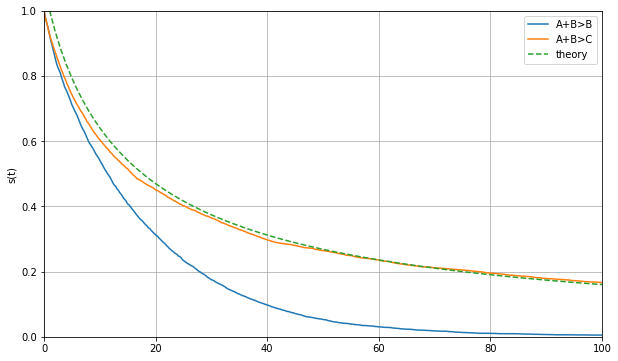

In [32]:
plt.figure(figsize=(10,6))
name=['A+B>B','A+B>C']
for i,(t,nt) in enumerate(result):
    plt.plot(t,nt,label=name[i])
    print(nt[-1])
plt.ylabel('s(t)')
plt.ylim(0,1)
plt.grid('on')
plt.xlim(0,100)
fn='/home/chew/spatiocyte_example/2D/output/2Dirrka689.98N100A351862_6575.csv'
tt,st= np.loadtxt(fn,delimiter=',').T
plt.plot(tt,st,'--',label='theory')

plt.legend()

0.00194
0.14618


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


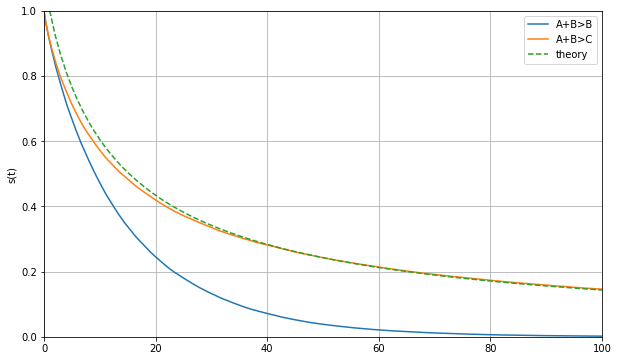

In [30]:
plt.figure(figsize=(10,6))
name=['A+B>B','A+B>C']
for i,(t,nt) in enumerate(result):
    plt.plot(t,nt,label=name[i])
    print(nt[-1])
plt.ylabel('s(t)')
plt.ylim(0,1)
plt.grid('on')
plt.xlim(0,100)
fn='/home/chew/spatiocyte_example/2D/output/2Dirrka1256.637N100A351862_6575.csv'
tt,st= np.loadtxt(fn,delimiter=',').T
plt.plot(tt,st,'--',label='theory')

plt.legend()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 400)

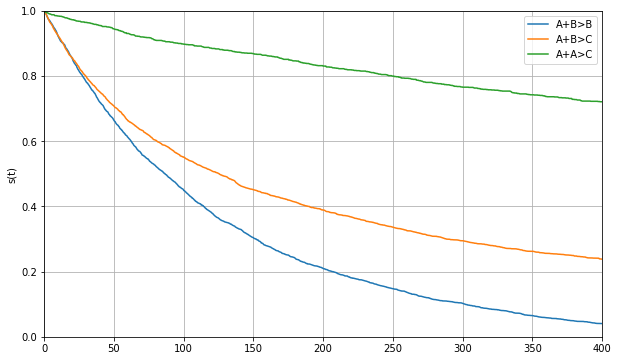

In [13]:
plt.figure(figsize=(10,6))
name=['A+B>B','A+B>C','A+A>C']
for i,(t,nt) in enumerate(result):
    plt.plot(t,nt,label=name[i])
plt.legend()
plt.ylabel('s(t)')
plt.ylim(0,1)
plt.grid('on')
plt.xlim(0,400)

(0, 400)

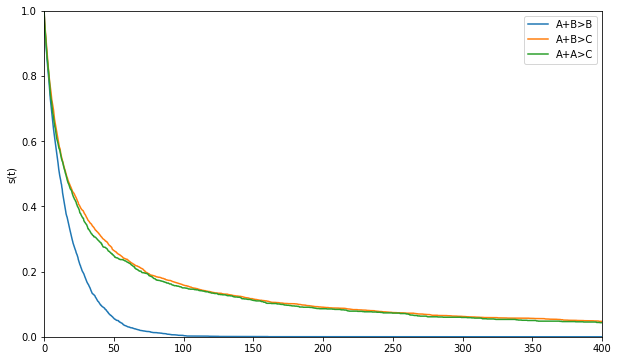

In [10]:
plt.figure(figsize=(10,6))
name=['A+B>B','A+B>C','A+A>C']
for i,(t,nt) in enumerate(result):
    plt.plot(t,nt,label=name[i])
plt.legend()
plt.ylabel('s(t)')
plt.ylim(0,1)
plt.xlim(0,400)

In [8]:
simrun=20000
kaf=100
nproc=500#250#
L=6.5
shift=40000
# works in low conc, deviate when conc is high
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift}]    
        #ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[02,12,27]'])[0]
        #ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

finish


In [32]:
fac = ((2*sqrt(2.0)+4*sqrt(3.0)+3*sqrt(6.0)+sqrt(22.0))/((6*sqrt(2.0)+4*sqrt(3.0)+3*sqrt(6.0))))**2
D=1
tmp=fac*voxelr**2/D
tmp,tmp/PP

(2.388834484739586e-05, 2.6042605691061394e-07)

In [33]:
fac*voxelr**2/tm

0.9168857180924649

In [45]:
100./6.5/6.5

2.366863905325444

In [46]:
int(2.37*6.5*6.5)

100

In [17]:
from ecell4 import *
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt,pi

kaf=0.01
nproc=500#250#
L=6.5
shift=0
conc=4.
rm = 0.005
run=1
correct='new'
rng = GSLRandomNumberGenerator()
rng.seed(run)
D = 1
kd= 4.0*math.pi*D
ka = kaf*kd
f=1.0208582         
if correct=='new':
    gamma=0.577216
    factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
    PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
    ka = PP*D/factor            
voxelr=rm*f
tm =(2*voxelr)**2/(4*D)        
duration=1#tm*5e4#tm*5e3
H = 3*voxelr*2
ori = Real3(0.5*H,0,0)
unit0 = Real3(0,0,L)
unit1 = Real3(0,L,0)
w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
Nmv=size[1]*size[2]
lx,ly,lz=w.actual_lengths()
N=int(conc*ly*lz)
print(lx,ly,lz)
print(size[0],size[1],size[2])
print(Nmv)
w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr),'location':'M'}
    B |  {'D': str(D), 'radius':str(voxelr),'location':'M'}

with reaction_rules():
    A + B > B | ka

m2 = get_model()
#print('ka',ka,'Rv',voxelr*2)
w.bind_to(m2)
w.add_molecules(Species('A'),2)


DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


0.05001163379472196 6.506896032581781 6.513075315999999
6 638 736
469568


In [18]:
for i in range(10):
    pid,p=w.list_particles(Species('M'))[i]
    print(tuple(p.position()))

(0.008335272299120327, 0.002946963782872184, 0.0051042909999999995)
(0.008335272299120327, 0.002946963782872184, 0.015312872999999998)
(0.008335272299120327, 0.002946963782872184, 0.025521455)
(0.008335272299120327, 0.002946963782872184, 0.035730037)
(0.008335272299120327, 0.002946963782872184, 0.04593861899999999)
(0.008335272299120327, 0.002946963782872184, 0.056147200999999994)
(0.008335272299120327, 0.002946963782872184, 0.06635578299999999)
(0.008335272299120327, 0.002946963782872184, 0.076564365)
(0.008335272299120327, 0.002946963782872184, 0.08677294699999999)
(0.008335272299120327, 0.002946963782872184, 0.096981529)


(0.008335272299120327, 3.6188715253670414, 1.755876104)

In [11]:
from math import sqrt
gam = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
gam, 1./2/sqrt(3)

(0.28986264423934294, 0.2886751345948129)

In [10]:
factor = ((2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))/((6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0))))**2            
factor,1

(0.9168857180924649, 1)